### import dependencies

In [1]:
import tensorflow
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.metrics import AUC, BinaryAccuracy,  TruePositives, TrueNegatives, Precision, Recall

In [2]:
# since model is trained on imagenet size should be 224x224
IMAGE_SIZE = [224, 224]

## Load datasets

In [3]:
train_path = './dataset/train'
test_path = './dataset/test'

In [4]:
train_dataget = ImageDataGenerator(
                                    preprocessing_function=preprocess_input,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_dataget = ImageDataGenerator(
                                    preprocessing_function=preprocess_input,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_set = train_dataget.flow_from_directory(train_path,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode = 'categorical')

test_set = test_dataget.flow_from_directory(test_path,
                                             target_size=(224,224),
                                             batch_size=32,
                                             class_mode = 'categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


## Model architecture

In [5]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
for layer in vgg.layers:
    layer.trainable = False

In [7]:
x = Flatten()(vgg.output)
prediction = Dense(2, activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
metrics_keras = [
                AUC(name="auc"),
                BinaryAccuracy(name="acc"),
                TruePositives(name="positive"),
                TrueNegatives(name="negative"),
                Precision(name="precision"),
                Recall(name="recall"),
]

adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
             optimizer=adam,
             metrics=metrics_keras)

In [9]:
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                              verbose=1, save_best_only=True)

lr_reduce = ReduceLROnPlateau(monitor='auc', mode="max", factor=0.2, min_delta=0.0001, patience=5, verbose=1)

callbacks = [lr_reduce, checkpoint]

# train the model with 100 epochs

In [10]:
start = datetime.now()

model_history=model.fit_generator(
                            train_set,
                            validation_data=test_set,
                            epochs=100,
                            steps_per_epoch= 2637 // train_set.batch_size,
                            validation_steps=630 // test_set.batch_size,
                            validation_freq=1,
                            callbacks=callbacks, 
                            verbose=1)

duration = datetime.now() - start
print("Training completed in time:  ", duration)

C:\Users\Shahzod\anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 1.2743 - auc: 0.7764 - acc: 0.7152 - positive: 1864.0000 - negative: 1862.0000 - precision: 0.7150 - recall: 0.7155
Epoch 1: val_loss improved from inf to 0.92448, saving model to best_model.h5
82/82 [==============================] - 184s 2s/step - loss: 1.2743 - auc: 0.7764 - acc: 0.7152 - positive: 1864.0000 - negative: 1862.0000 - precision: 0.7150 - recall: 0.7155 - val_loss: 0.9245 - val_auc: 0.8567 - val_acc: 0.7862 - val_positive: 478.0000 - val_negative: 478.0000 - val_precision: 0.7862 - val_recall: 0.7862 - lr: 1.0000e-04
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.9123 - auc: 0.8559 - acc: 0.7868 - positive: 2055.0000 - negative: 2044.0000 - precision: 0.7856 - recall: 0.7889
Epoch 2: val_loss improved from 0.92448 to 0.88811, saving model to best_model.h5
82/82 [==============================] - 189s 2s/step - loss: 0.9123 - auc: 0.8559 - acc: 0.7868 - positive: 2055.0000 - nega

Epoch 15/100
82/82 [==============================] - ETA: 0s - loss: 0.5034 - auc: 0.9230 - acc: 0.8509 - positive: 2207.0000 - negative: 2226.0000 - precision: 0.8534 - recall: 0.8472
Epoch 15: val_loss did not improve from 0.61015
82/82 [==============================] - 192s 2s/step - loss: 0.5034 - auc: 0.9230 - acc: 0.8509 - positive: 2207.0000 - negative: 2226.0000 - precision: 0.8534 - recall: 0.8472 - val_loss: 0.6862 - val_auc: 0.8911 - val_acc: 0.7993 - val_positive: 485.0000 - val_negative: 487.0000 - val_precision: 0.8003 - val_recall: 0.7977 - lr: 1.0000e-04
Epoch 16/100
82/82 [==============================] - ETA: 0s - loss: 0.4769 - auc: 0.9288 - acc: 0.8509 - positive: 2228.0000 - negative: 2205.0000 - precision: 0.8478 - recall: 0.8553
Epoch 16: val_loss did not improve from 0.61015
82/82 [==============================] - 193s 2s/step - loss: 0.4769 - auc: 0.9288 - acc: 0.8509 - positive: 2228.0000 - negative: 2205.0000 - precision: 0.8478 - recall: 0.8553 - val_los

Epoch 29/100
82/82 [==============================] - ETA: 0s - loss: 0.4019 - auc: 0.9417 - acc: 0.8724 - positive: 2273.0000 - negative: 2272.0000 - precision: 0.8722 - recall: 0.8726
Epoch 29: val_loss did not improve from 0.54093
82/82 [==============================] - 192s 2s/step - loss: 0.4019 - auc: 0.9417 - acc: 0.8724 - positive: 2273.0000 - negative: 2272.0000 - precision: 0.8722 - recall: 0.8726 - val_loss: 0.5821 - val_auc: 0.9091 - val_acc: 0.8240 - val_positive: 504.0000 - val_negative: 498.0000 - val_precision: 0.8208 - val_recall: 0.8289 - lr: 1.0000e-04
Epoch 30/100
82/82 [==============================] - ETA: 0s - loss: 0.4113 - auc: 0.9393 - acc: 0.8643 - positive: 2245.0000 - negative: 2258.0000 - precision: 0.8661 - recall: 0.8618
Epoch 30: val_loss did not improve from 0.54093
82/82 [==============================] - 194s 2s/step - loss: 0.4113 - auc: 0.9393 - acc: 0.8643 - positive: 2245.0000 - negative: 2258.0000 - precision: 0.8661 - recall: 0.8618 - val_los

Epoch 43/100
82/82 [==============================] - ETA: 0s - loss: 0.3348 - auc: 0.9524 - acc: 0.8871 - positive: 2311.0000 - negative: 2311.0000 - precision: 0.8871 - recall: 0.8871
Epoch 43: val_loss did not improve from 0.50132
82/82 [==============================] - 192s 2s/step - loss: 0.3348 - auc: 0.9524 - acc: 0.8871 - positive: 2311.0000 - negative: 2311.0000 - precision: 0.8871 - recall: 0.8871 - val_loss: 0.5050 - val_auc: 0.9234 - val_acc: 0.8413 - val_positive: 515.0000 - val_negative: 508.0000 - val_precision: 0.8374 - val_recall: 0.8470 - lr: 2.0000e-05
Epoch 44/100
82/82 [==============================] - ETA: 0s - loss: 0.3266 - auc: 0.9544 - acc: 0.8891 - positive: 2326.0000 - negative: 2306.0000 - precision: 0.8861 - recall: 0.8929
Epoch 44: val_loss did not improve from 0.50132
82/82 [==============================] - 194s 2s/step - loss: 0.3266 - auc: 0.9544 - acc: 0.8891 - positive: 2326.0000 - negative: 2306.0000 - precision: 0.8861 - recall: 0.8929 - val_los

82/82 [==============================] - ETA: 0s - loss: 0.2985 - auc: 0.9588 - acc: 0.8948 - positive: 2332.0000 - negative: 2330.0000 - precision: 0.8945 - recall: 0.8952
Epoch 57: val_loss did not improve from 0.44071
82/82 [==============================] - 190s 2s/step - loss: 0.2985 - auc: 0.9588 - acc: 0.8948 - positive: 2332.0000 - negative: 2330.0000 - precision: 0.8945 - recall: 0.8952 - val_loss: 0.4686 - val_auc: 0.9307 - val_acc: 0.8544 - val_positive: 524.0000 - val_negative: 515.0000 - val_precision: 0.8493 - val_recall: 0.8618 - lr: 2.0000e-05
Epoch 58/100
82/82 [==============================] - ETA: 0s - loss: 0.3082 - auc: 0.9568 - acc: 0.8825 - positive: 2297.0000 - negative: 2301.0000 - precision: 0.8831 - recall: 0.8818
Epoch 58: val_loss did not improve from 0.44071
82/82 [==============================] - 194s 2s/step - loss: 0.3082 - auc: 0.9568 - acc: 0.8825 - positive: 2297.0000 - negative: 2301.0000 - precision: 0.8831 - recall: 0.8818 - val_loss: 0.5285 - v

Epoch 71/100
82/82 [==============================] - ETA: 0s - loss: 0.2970 - auc: 0.9590 - acc: 0.8914 - positive: 2328.0000 - negative: 2316.0000 - precision: 0.8896 - recall: 0.8937
Epoch 71: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.

Epoch 71: val_loss did not improve from 0.44071
82/82 [==============================] - 193s 2s/step - loss: 0.2970 - auc: 0.9590 - acc: 0.8914 - positive: 2328.0000 - negative: 2316.0000 - precision: 0.8896 - recall: 0.8937 - val_loss: 0.5042 - val_auc: 0.9192 - val_acc: 0.8396 - val_positive: 510.0000 - val_negative: 511.0000 - val_precision: 0.8402 - val_recall: 0.8388 - lr: 8.0000e-07
Epoch 72/100
82/82 [==============================] - ETA: 0s - loss: 0.2781 - auc: 0.9616 - acc: 0.8906 - positive: 2312.0000 - negative: 2328.0000 - precision: 0.8930 - recall: 0.8875
Epoch 72: val_loss did not improve from 0.44071
82/82 [==============================] - 197s 2s/step - loss: 0.2781 - auc: 0.9616 - acc: 0.8906 - positive: 

Epoch 85/100
82/82 [==============================] - ETA: 0s - loss: 0.3106 - auc: 0.9566 - acc: 0.8858 - positive: 2320.0000 - negative: 2295.0000 - precision: 0.8821 - recall: 0.8906
Epoch 85: val_loss did not improve from 0.42558
82/82 [==============================] - 192s 2s/step - loss: 0.3106 - auc: 0.9566 - acc: 0.8858 - positive: 2320.0000 - negative: 2295.0000 - precision: 0.8821 - recall: 0.8906 - val_loss: 0.5061 - val_auc: 0.9236 - val_acc: 0.8470 - val_positive: 516.0000 - val_negative: 514.0000 - val_precision: 0.8459 - val_recall: 0.8487 - lr: 6.4000e-09
Epoch 86/100
82/82 [==============================] - ETA: 0s - loss: 0.3192 - auc: 0.9551 - acc: 0.8891 - positive: 2300.0000 - negative: 2332.0000 - precision: 0.8939 - recall: 0.8829
Epoch 86: val_loss did not improve from 0.42558
82/82 [==============================] - 194s 2s/step - loss: 0.3192 - auc: 0.9551 - acc: 0.8891 - positive: 2300.0000 - negative: 2332.0000 - precision: 0.8939 - recall: 0.8829 - val_los

Epoch 99/100
82/82 [==============================] - ETA: 0s - loss: 0.2955 - auc: 0.9603 - acc: 0.8950 - positive: 2332.0000 - negative: 2331.0000 - precision: 0.8949 - recall: 0.8952
Epoch 99: val_loss did not improve from 0.42249
82/82 [==============================] - 195s 2s/step - loss: 0.2955 - auc: 0.9603 - acc: 0.8950 - positive: 2332.0000 - negative: 2331.0000 - precision: 0.8949 - recall: 0.8952 - val_loss: 0.4961 - val_auc: 0.9236 - val_acc: 0.8495 - val_positive: 516.0000 - val_negative: 517.0000 - val_precision: 0.8501 - val_recall: 0.8487 - lr: 2.5600e-10
Epoch 100/100
82/82 [==============================] - ETA: 0s - loss: 0.3161 - auc: 0.9551 - acc: 0.8866 - positive: 2320.0000 - negative: 2299.0000 - precision: 0.8835 - recall: 0.8906
Epoch 100: val_loss did not improve from 0.42249
82/82 [==============================] - 193s 2s/step - loss: 0.3161 - auc: 0.9551 - acc: 0.8866 - positive: 2320.0000 - negative: 2299.0000 - precision: 0.8835 - recall: 0.8906 - val_l

In [13]:
model_history.history.keys()

dict_keys(['loss', 'auc', 'acc', 'positive', 'negative', 'precision', 'recall', 'val_loss', 'val_auc', 'val_acc', 'val_positive', 'val_negative', 'val_precision', 'val_recall', 'lr'])

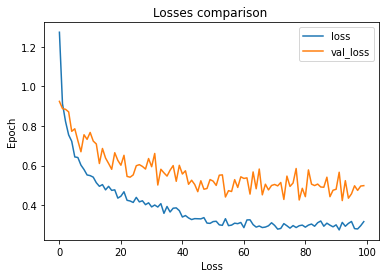

In [14]:
import matplotlib.pyplot as plt

plt.title('Losses comparison ')
plt.plot(model_history.history.get('loss'), label='loss')
plt.plot(model_history.history.get('val_loss'), label='val_loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend()

In [15]:
model_history.history

{'loss': [1.2742924690246582,
  0.9122977256774902,
  0.8220303058624268,
  0.7550947070121765,
  0.7227153778076172,
  0.6434211134910583,
  0.6406369805335999,
  0.6021507978439331,
  0.5797320604324341,
  0.5522443652153015,
  0.5489218831062317,
  0.5411645770072937,
  0.5130136609077454,
  0.4948704242706299,
  0.5034021735191345,
  0.47689029574394226,
  0.49464133381843567,
  0.47425299882888794,
  0.47696515917778015,
  0.4350612759590149,
  0.44473373889923096,
  0.4671701490879059,
  0.424052357673645,
  0.4205182194709778,
  0.41313162446022034,
  0.438821017742157,
  0.4160769283771515,
  0.42159464955329895,
  0.4019327759742737,
  0.41128379106521606,
  0.3906456530094147,
  0.4001179039478302,
  0.3899914622306824,
  0.4071555733680725,
  0.3580264449119568,
  0.3926863670349121,
  0.3648426830768585,
  0.384025901556015,
  0.3856808841228485,
  0.37172532081604004,
  0.3394094407558441,
  0.34682947397232056,
  0.3348223865032196,
  0.32663074135780334,
  0.331280261278